In [1]:
import json
import matplotlib.pyplot as plt

from pathlib import Path
from cpymad.madx import Madx
import xobjects as xo
import xpart as xp
import xdeps as xd
import xtrack as xt
from xtrack.slicing import Teapot, Strategy
from xtrack.twiss import TwissInit

from toolkit import matching_functions as mfct
from toolkit import plotkit as pl

%matplotlib inline

In [2]:
print(f'Xparts version: {xp.__version__}')
print(f'Xdeps version: {xd.__version__}')
print(f'Xtrack version: {xt.__version__}')
print(f'Xobjects version: {xo.__version__}')

Xparts version: 0.15.2
Xdeps version: 0.4.1
Xtrack version: 0.41.2
Xobjects version: 0.2.7


In [3]:
OPERATION_MODE = 't'
REFERENCE_PARAMETER = json.load(open('./reference_parameters.json'))
MATCHING_PARAMETERS={
    't':{
        'muxu' : 1.29939516129,
        'muyu' : 1.154838709677,
        'mux_sf' : 0.500165,
        'mux_sd' : 0.50114,
        'muy_sd' : 0.5054,
        'bxsu' : 1.261E2,
        'bysu' : 1.341E2,
        'bxmax' : 2.73E2,
        'bymax' : 2.73E2,
        'bxsc' : 71.0,
        'bysc' : 2.375E2,
        'bx_ff_in' : 50.0,
        'by_ff_in' : 1.0E3,
        'dx_ff_in' : 0.0,
        'bxip' : 1.0,
        'byip' : 0.16E-2,
        'bysdff' : 3.5E3,
        'dmuy_sdy1' : -0.83E-4,
        'dpx_ccy' : 0.0,
        'r12_ccsy' : -0.189,
        'r34_ccsy' : -0.25,
        'bxsfff' : 3.0E2,
        'dx_sfm' : 0.1,
        'dmux_sfx1' : -0.022,
        'dx_ccx' : 0.0,
        'dpx_ccx' : 0.0,
        'bx_ff_out' : 50.0,
        'by_ff_out' : 1e3,
        'dx_ff_out' : 0.0,
        'r12_ccsx' : 0.0,
        'r34_ccsx' : 0.0,
    }
}

In [4]:
#  Load thick Mad-X lattice and convert to Xtrack line

if Path(f'fccee_{OPERATION_MODE}.json').exists():
    with open(f'fccee_{OPERATION_MODE}.json', 'r', encoding='utf-8') as fid:
        loaded_dct = json.load(fid)

    line = xt.Line.from_dict(loaded_dct)

else:
    with Madx() as madx:
        madx.call(f'./lattices/{OPERATION_MODE}/fccee_{OPERATION_MODE}.seq')
        madx.command.beam()
        madx.use('FCCEE_P_RING')
        madx.call(f'./toolkit/install_matching_markers.madx')

        line = xt.Line.from_madx_sequence(
            madx.sequence['FCCEE_P_RING'],
            allow_thick=True,
            deferred_expressions=True,
        )

    # Save to json

    with open(f'fccee_{OPERATION_MODE}.json', 'w', encoding='utf-8') as fid:
        json.dump(line.to_dict(), fid, cls=xo.JEncoder)

Done loading line from dict.           


In [5]:
# build tracker for thick line, run twiss and check optics
ref_particle = xp.Particles(
        mass0=xp.ELECTRON_MASS_EV,
        q0=1,
        p0c=REFERENCE_PARAMETER[OPERATION_MODE]['ENERGY']*1e9,
        x=0,
        y=0
        )
line.particle_ref = ref_particle

line.build_tracker()
thick_twiss = line.twiss().to_pandas()
thick_twiss

Found suitable prebuilt kernel `default_only_xtrack`.


name             s             x            px  \
0      fccee_p_ring$start      0.000000  2.075471e-11  2.959908e-11   
1                      ip      0.000000  2.075471e-11  2.959908e-11   
2                     ipa      0.000000  2.075471e-11  2.959908e-11   
3                      d0      0.000000  2.075471e-11  2.959908e-11   
4             qd0al_entry      2.200000  8.587269e-11  2.959908e-11   
...                   ...           ...           ...           ...   
66061                d0:6  91483.610288  7.525371e-11 -2.075115e-11   
66062                ip:6  91485.810288  2.960118e-11 -2.075115e-11   
66063               ipa.l  91485.810288  2.960118e-11 -2.075115e-11   
66064    fccee_p_ring$end  91485.810288  2.960118e-11 -2.075115e-11   
66065          _end_point  91485.810288  2.960118e-11 -2.075115e-11   

                  y            py      zeta         delta          ptau  \
0     -8.286405e-23  1.081894e-20 -0.067767 -1.851408e-12 -1.851408e-12   
1     -8.286405e-23  1.081894e-20 -0.067767 -1.851408e-12 -1.851408e-12   
2     -8.286405e-23  1.081894e-20 -0.067767 -1.851408e-12 -1.851408e-12   
3     -8.286405e-23  1.081894e-20 -0.067767 -1.851408e-12 -1.851408e-12   
4      2.371879e-20  1.081894e-20 -0.067767 -1.851408e-12 -1.851408e-12   
...             ...           ...       ...           ...           ...   
66061 -4.702369e-20  2.140956e-20 -0.067767  3.881784e-12  3.881809e-12   
66062  7.734190e-23  2.140956e-20 -0.067767  3.881784e-12  3.881809e-12   
66063  7.734190e-23  2.140956e-20 -0.067767  3.881784e-12  3.881809e-12   
66064  7.734190e-23  2.140956e-20 -0.067767  3.881784e-12  3.881809e-12   
66065  7.734190e-23  2.140956e-20 -0.067767  3.881784e-12  3.881809e-12   

           betx  ...         mux         muy    muzeta  nux  nuy   nuzeta  \
0      1.000004  ...    0.000000    0.000000  0.000000  1.0  1.0  1.00000   
1      1.000004  ...    0.000000    0.000000  0.000000  1.0  1.0  1.00000   
2      1.000004  ...    0.000000    0.000000  0.000000  1.0  1.0  1.00000   
3      1.000004  ...    0.000000    0.000000  0.000000  1.0  1.0  1.00000   
4      5.840038  ...    0.182098    0.250048  0.000000  1.0  1.0  1.00000   
...         ...  ...         ...         ...       ...  ...  ...      ...   
66061  5.839930  ...  362.067882  322.151037 -0.103633  1.0  1.0  0.99986   
66062  1.000004  ...  362.249983  322.400757 -0.103633  1.0  1.0  0.99986   
66063  1.000004  ...  362.249983  322.400757 -0.103633  1.0  1.0  0.99986   
66064  1.000004  ...  362.249983  322.400757 -0.103633  1.0  1.0  0.99986   
66065  1.000004  ...  362.249983  322.400757 -0.103633  1.0  1.0  0.99986   

                                                W_matrix     dzeta      dmux  \
0      [[1.0000020819826327, 1.2246493488407203e-16, ...  0.000000  0.000000   
1      [[1.0000020819826327, 1.2246493488407203e-16, ...  0.000000  0.000000   
2      [[1.0000020819826327, 1.2246493488407203e-16, ...  0.000000  0.000000   
3      [[1.0000020819826327, 1.2246493488407203e-16, ...  0.000000  0.000000   
4      [[2.416617032742776, -1.7844994157106065e-17, ...  0.000000 -0.182491   
...                                                  ...       ...       ...   
66061  [[2.416594744293914, 1.786135794106002e-16, -1... -0.975354  1.969571   
66062  [[1.000002081344415, -9.60483860218375e-18, -2... -0.975354  1.836987   
66063  [[1.000002081344415, -9.60483860218375e-18, -2... -0.975354  1.836987   
66064  [[1.000002081344415, -9.60483860218375e-18, -2... -0.975354  1.836987   
66065  [[1.000002081344415, -9.60483860218375e-18, -2... -0.975354  1.836987   

           dmuy  
0      0.000000  
1      0.000000  
2      0.000000  
3      0.000000  
4     -0.098894  
...         ...  
66061  0.654172  
66062  0.751599  
66063  0.751599  
66064  0.751599  
66065  0.751599  

[66066 rows x 35 columns]

In [6]:
# make twiss for before/after comparison
cell_uu = line.twiss(
    ele_start='s.arc_uu',
    ele_stop='e.arc_uu',
    twiss_init='periodic',
    method='4d',
)
cell_uu_thick_df = cell_uu.to_pandas().set_index('name')


cell_ussu = line.twiss(
    ele_start='s.arc_ussu',
    ele_stop='e.arc_ussu',
    twiss_init=TwissInit(
            betx=cell_uu['betx', -1],
            bety=cell_uu['bety', -1],
            dx=cell_uu['dx', -1],
        ),
    method='4d',
)
cell_ussu_thick_df = cell_ussu.to_pandas().set_index('name')


cell_uffu = line.twiss(
    ele_start='s.arc_uffu',
    ele_stop='e.arc_uffu',
    twiss_init=TwissInit(
            betx=cell_uu['betx', -1],
            bety=cell_uu['bety', -1],
            dx=cell_uu['dx', -1],
        ),
    method='4d',
)
cell_uffu_thick_df = cell_uffu.to_pandas().set_index('name')

cell_ufl = line.twiss(
    ele_start='s.arc_uffu',
    ele_stop='ccs_xl.d',
    twiss_init=TwissInit(
            betx=cell_uu['betx', -1],
            bety=cell_uu['bety', -1],
            dx=cell_uu['dx', -1],
        ),
    method='4d',
)
cell_ufl_thick_df = cell_ufl.to_pandas().set_index('name')

bx_ff_in = 50.0
by_ff_in = 1.0E3
dx_ff_in = 0.0
cell_ufr = line.twiss(
    ele_start='ccs_xr.d',
    ele_stop='e.arc_uffu',
    twiss_init=TwissInit(
        betx=bx_ff_in,
        bety=by_ff_in,
        dx=dx_ff_in,
    ),
    method='4d',
)
cell_ufr_thick_df = cell_ufr.to_pandas().set_index('name')

bxip = 1.0
byip = 0.16E-2
cell_mccs_yl = line.twiss(
    # ele_start='ipd',
    # ele_stop='ccs_yl.d',
    ele_stop='ipd',
    ele_start='ccs_yl.d',
    reverse=False,
    twiss_init=TwissInit(
        betx=bxip,
        bety=byip,
        element_name='ipd'
    ),
    method='4d',
)
cell_mccs_yl_thick_df = cell_mccs_yl.to_pandas().set_index('name')

cell_mccs_yxl = line.twiss(
    # ele_start='ipd',
    # ele_stop='ccs_xl.d',
    ele_stop='ipd',
    ele_start='ccs_xl.d',
    reverse=False,
    twiss_init=TwissInit(
        betx=bxip,
        bety=byip,
        element_name='ipd'
    ),
    method='4d',
)
cell_mccs_yxl_thick_df = cell_mccs_yxl.to_pandas().set_index('name')

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `only_xtrack_backtrack_frozen_energy`.
Found suitable prebuilt kernel `default_bb3d`.


Using solver jacobian
Found point within tolerance!   
penalty: 1.3632821276766363e-07
new best: 1.3632821276766363e-07
Vary:
id tag state description                                         
 0     ON    Vary(name=kqd1, limits=None, step=1e-10, weight=1.0)
 1     ON    Vary(name=kqf2, limits=None, step=1e-10, weight=1.0)
 2     ON    Vary(name=kqd3, limits=None, step=1e-10, weight=1.0)
 3     ON    Vary(name=kqf4, limits=None, step=1e-10, weight=1.0)
 4     ON    Vary(name=kqd5, limits=None, step=1e-10, weight=1.0)
 5     ON    Vary(name=kqf6, limits=None, step=1e-10, weight=1.0)
Targets:
id tag state description                                                                            
 0     ON    TargetInequality(('bety', 'sd1a_exit:64') > 132.1, tol=0.0001, weight=1.0)             
 1     ON    Target(tar=('mux', 'sd1a_exit:64'), value=0.25057, tol=0.0001, weight=10.0)            
 2     ON    Target(tar=('muy', 'sd1a_exit:64'), value=0.2527, tol=0.0001, weight=10.0)             

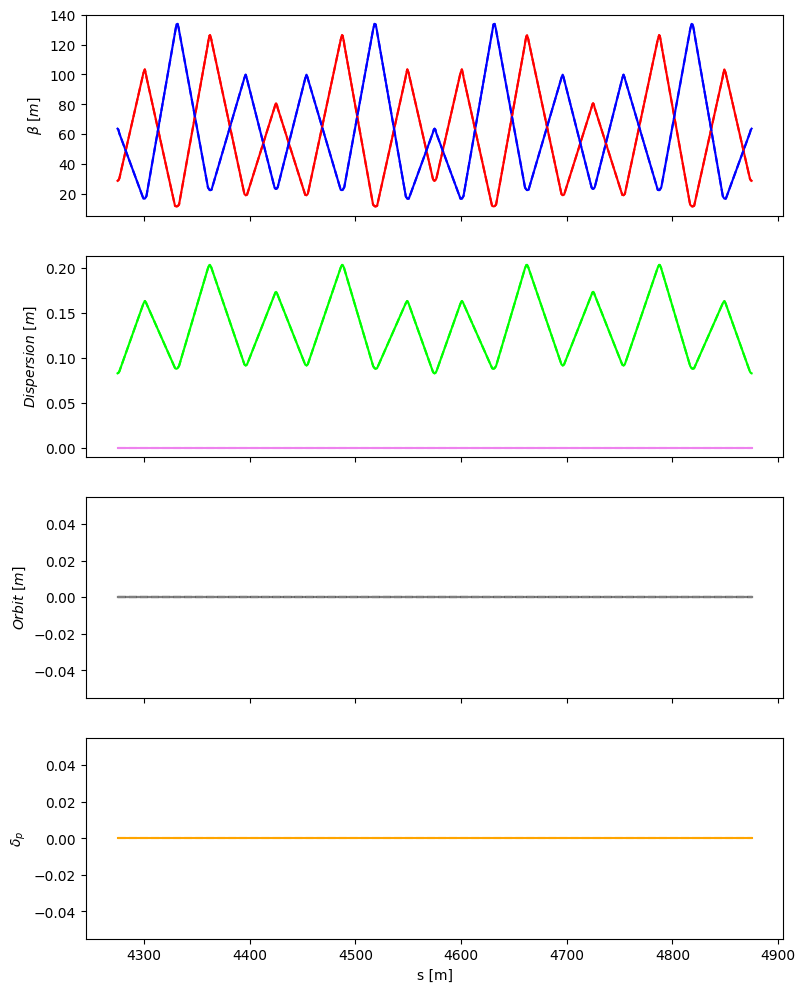

In [7]:
result = mfct.rematch_arcuu(line, MATCHING_PARAMETERS[OPERATION_MODE])

result.show()
result.solve()

cell_uu = line.twiss(
    ele_start='s.arc_uu',
    ele_stop='e.arc_uu',
    twiss_init='periodic',
    method='4d',
)
cell_uu_df_rematched = cell_uu.to_pandas()

pl.compare_twiss(cell_uu_thick_df, cell_uu_df_rematched)

In [8]:
result.log()

Table: 2 rows, 22 cols
iteration     penalty alpha tol_met target_active hit_limits vary_active     vary_0    vary_1 ...
        0 1.36328e-07    -1 yyyyyyy yyyyyyy       nnnnnn     yyyyyy      -0.0194262 0.0197114
        1         nan  None yyyyyyy yyyyyyy       nnnnnn     yyyyyy      -0.0194262 0.0197114

Found suitable prebuilt kernel `default_bb3d`.
Using solver jacobian
Found point within tolerance!   
penalty: 1.2160262878940588e-06
new best: 1.2160262878940588e-06
Vary:
id tag state description                                          
 0     ON    Vary(name=kqfs1, limits=None, step=1e-10, weight=1.0)
 1     ON    Vary(name=kqds2, limits=None, step=1e-10, weight=1.0)
 2     ON    Vary(name=kqfs3, limits=None, step=1e-10, weight=1.0)
 3     ON    Vary(name=kqds4, limits=None, step=1e-10, weight=1.0)
 4     ON    Vary(name=kqfs5, limits=None, step=1e-10, weight=1.0)
 5     ON    Vary(name=kqdl1, limits=None, step=1e-10, weight=1.0)
 6     ON    Vary(name=kqfl2, limits=None, step=1e-10, weight=1.0)
 7     ON    Vary(name=kqdl2, limits=None, step=1e-10, weight=1.0)
 8     ON    Vary(name=kqfl3, limits=None, step=1e-10, weight=1.0)
 9     ON    Vary(name=kqdl3, limits=None, step=1e-10, weight=1.0)
10     ON    Vary(name=kqdl4, limits=None, step=1e-10, weight=1.0)
Targets:
id tag state d

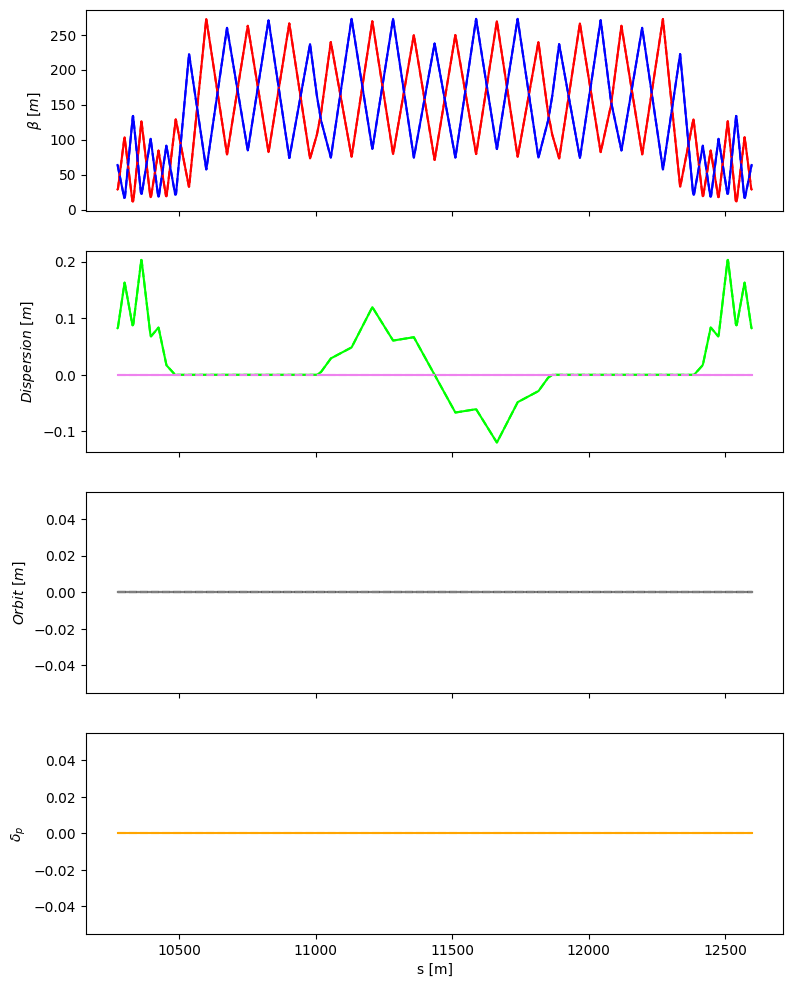

In [9]:
result = mfct.rematch_arcussu(line, MATCHING_PARAMETERS[OPERATION_MODE])

result.show()
result.solve()

cell_ussu = line.twiss(
    ele_start='s.arc_ussu',
    ele_stop='e.arc_ussu',
    twiss_init=TwissInit(
            betx=cell_uu['betx', -1],
            bety=cell_uu['bety', -1],
            dx=cell_uu['dx', -1],
        ),
    method='4d',
)
cell_ussu_df_rematched = cell_ussu.to_pandas()

pl.compare_twiss(cell_ussu_thick_df, cell_ussu_df_rematched)

In [10]:
result.log()

Table: 2 rows, 42 cols
iteration     penalty alpha tol_met                target_active          hit_limits  vary_active ...
        0 1.21603e-06    -1 yyyyyyyyyyyyyyyyyyyyyy yyyyyyyyyyyyyyyyyyyyyy nnnnnnnnnnn yyyyyyyyyyy
        1         nan  None yyyyyyyyyyyyyyyyyyyyyy yyyyyyyyyyyyyyyyyyyyyy nnnnnnnnnnn yyyyyyyyyyy

Found suitable prebuilt kernel `default_bb3d`.
Using solver jacobian
Found point within tolerance!   
penalty: 1.1175422297387996e-06
new best: 1.1175422297387996e-06
Vary:
id tag state description                                           
 0     ON    Vary(name=kqfm1l, limits=None, step=1e-10, weight=1.0)
 1     ON    Vary(name=kqdm2l, limits=None, step=1e-10, weight=1.0)
 2     ON    Vary(name=kqfm3l, limits=None, step=1e-10, weight=1.0)
 3     ON    Vary(name=kqdm4l, limits=None, step=1e-10, weight=1.0)
 4     ON    Vary(name=kqfm5l, limits=None, step=1e-10, weight=1.0)
 5     ON    Vary(name=kqdm6l, limits=None, step=1e-10, weight=1.0)
 6     ON    Vary(name=kqfm7l, limits=None, step=1e-10, weight=1.0)
 7     ON    Vary(name=kqdm8l, limits=None, step=1e-10, weight=1.0)
Targets:
id tag state description                                                                            
 0     ON    Target(tar=('betx', 'scrabl_exit:0'), value=50.0, tol=0.0001, weight=1.0)              
 1  

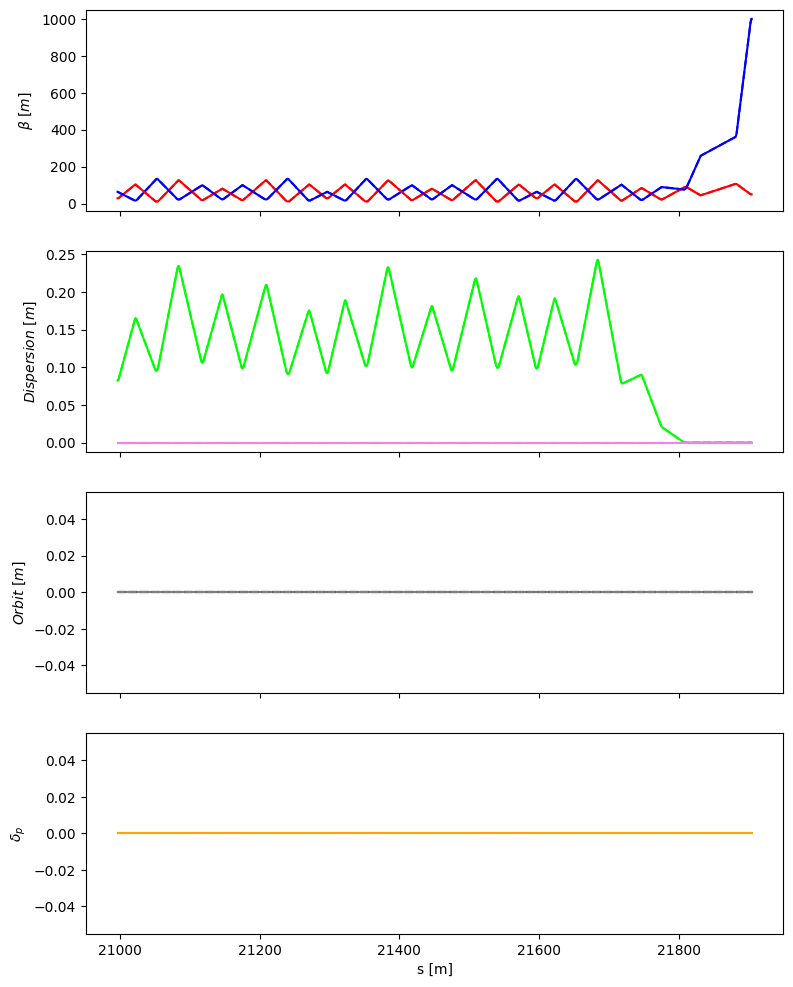

In [11]:
result = mfct.rematch_arcufl(line, MATCHING_PARAMETERS[OPERATION_MODE])

result.show()
result.solve()

cell_ufl = line.twiss(
    ele_start='s.arc_uffu',
    ele_stop='ccs_xl.d',
    twiss_init=TwissInit(
            betx=cell_uu['betx', -1],
            bety=cell_uu['bety', -1],
            dx=cell_uu['dx', -1],
        ),
    method='4d',
)
cell_ufl_df_rematched = cell_ufl.to_pandas()

pl.compare_twiss(cell_ufl_thick_df, cell_ufl_df_rematched)

In [12]:
result.log()


Table: 2 rows, 25 cols
iteration     penalty alpha tol_met  target_active hit_limits vary_active    vary_0     vary_1 ...
        0 1.11754e-06    -1 yyyyyyyy yyyyyyyy      nnnnnnnn   yyyyyyyy    0.0202774 -0.0211046
        1         nan  None yyyyyyyy yyyyyyyy      nnnnnnnn   yyyyyyyy    0.0202774 -0.0211046

Found suitable prebuilt kernel `default_bb3d`.
Using solver jacobian
Found point within tolerance!   
penalty: 4.752937260144456e-07
new best: 4.752937260144456e-07
Vary:
id tag state description                                           
 0     ON    Vary(name=kqfm1r, limits=None, step=1e-10, weight=1.0)
 1     ON    Vary(name=kqdm2r, limits=None, step=1e-10, weight=1.0)
 2     ON    Vary(name=kqfm3r, limits=None, step=1e-10, weight=1.0)
 3     ON    Vary(name=kqdm4r, limits=None, step=1e-10, weight=1.0)
 4     ON    Vary(name=kqfm5r, limits=None, step=1e-10, weight=1.0)
 5     ON    Vary(name=kqdm6r, limits=None, step=1e-10, weight=1.0)
 6     ON    Vary(name=kqfm7r, limits=None, step=1e-10, weight=1.0)
 7     ON    Vary(name=kqdm8r, limits=None, step=1e-10, weight=1.0)
Targets:
id tag state description                                                                         
 0     ON    Target(tar=('betx', 'e.arc_uffu'), value=28.810857017899828, tol=0.0001, weight=1.0)
 1     ON   

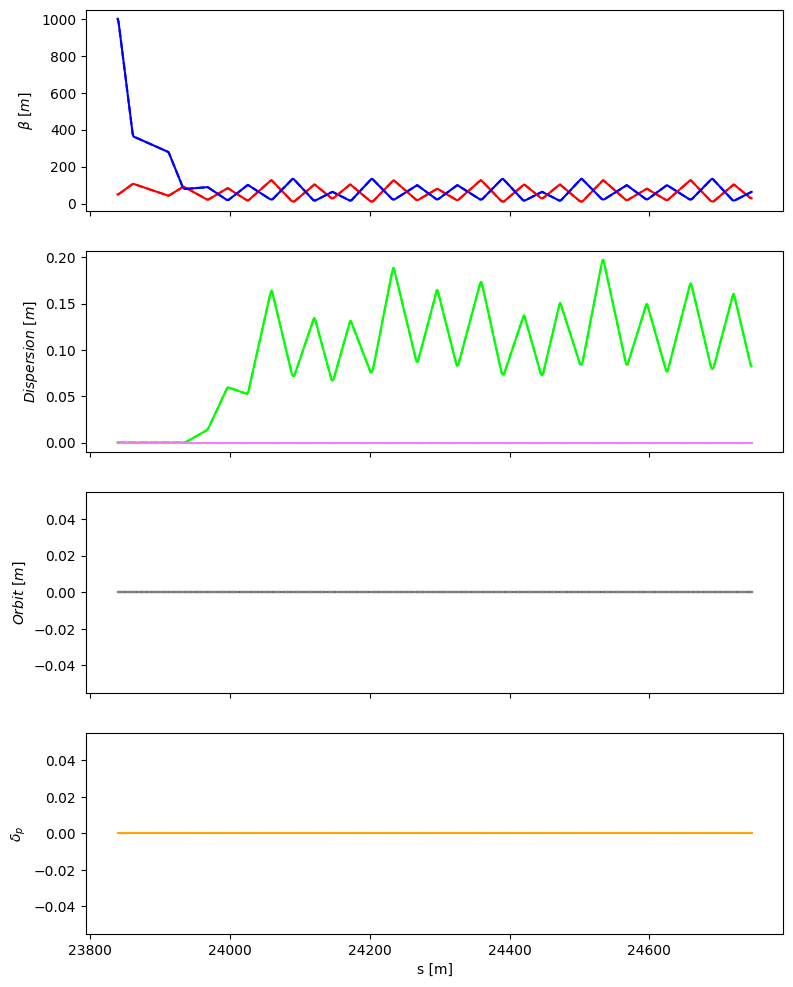

In [13]:
result = mfct.rematch_arcufr(line, MATCHING_PARAMETERS[OPERATION_MODE])

result.show()
result.solve()

cell_ufr = line.twiss(
    ele_start='ccs_xr.d',
    ele_stop='e.arc_uffu',
    twiss_init=TwissInit(
        betx=bx_ff_in,
        bety=by_ff_in,
        dx=dx_ff_in,
    ),
    method='4d',
)
cell_ufr_df_rematched = cell_ufr.to_pandas()

pl.compare_twiss(cell_ufr_thick_df, cell_ufr_df_rematched)

In [14]:
result.log()

Table: 2 rows, 25 cols
iteration     penalty alpha tol_met  target_active hit_limits vary_active    vary_0     vary_1 ...
        0 4.75294e-07    -1 yyyyyyyy yyyyyyyy      nnnnnnnn   yyyyyyyy    0.0198635 -0.0212101
        1         nan  None yyyyyyyy yyyyyyyy      nnnnnnnn   yyyyyyyy    0.0198635 -0.0212101

In [15]:
result = mfct.rematch_mccs_yl(line, MATCHING_PARAMETERS[OPERATION_MODE])
result.target_status()

Found suitable prebuilt kernel `default_bb3d`.
Using solver jacobian
Found point within tolerance!   
penalty: 4.0587409064973495e-06
new best: 4.0587409064973495e-06
id state tag tol_met  current_val target_val ...
 0 ON           True            0          0
 1 ON           True            0          0
 2 ON           True            0          0
 3 ON           True  6.30093e-09          0
 4 ON           True            0          0
 5 ON           True         3500       3500
 6 ON           True -7.42644e-09          0
 7 ON           True            0          0
 8 ON           True    -0.749917  -0.749917
 9 ON           True            0          0
10 ON           True -7.39839e-10          0
11 ON           True  4.97509e-09          0
12 ON           True            0          0
13 ON           True -7.37544e-12          0
14 ON           True    -0.188996     -0.189
15 ON           True        -0.25      -0.25
16 ON           True           -1         -1
17 ON           Tru

Found suitable prebuilt kernel `default_bb3d`.
Using solver jacobian
Found point within tolerance!   
penalty: 4.0587409064973495e-06
new best: 4.0587409064973495e-06
Vary:
id tag state description                                           
 0     ON    Vary(name=kqd0al, limits=None, step=1e-10, weight=1.0)
 1     ON    Vary(name=kqf1al, limits=None, step=1e-10, weight=1.0)
 2     ON    Vary(name=kqy01, limits=None, step=1e-10, weight=1.0) 
 3     ON    Vary(name=kqy02, limits=None, step=1e-10, weight=1.0) 
 4     ON    Vary(name=kqy03, limits=None, step=1e-10, weight=1.0) 
 5     ON    Vary(name=kqd02, limits=None, step=1e-10, weight=1.0) 
 6     ON    Vary(name=kqd04, limits=None, step=1e-10, weight=1.0) 
 7     ON    Vary(name=kqf05, limits=None, step=1e-10, weight=1.0) 
 8     ON    Vary(name=kqd06, limits=None, step=1e-10, weight=1.0) 
Targets:
id tag state description                                                                               
 0     ON    TargetInequality(('be

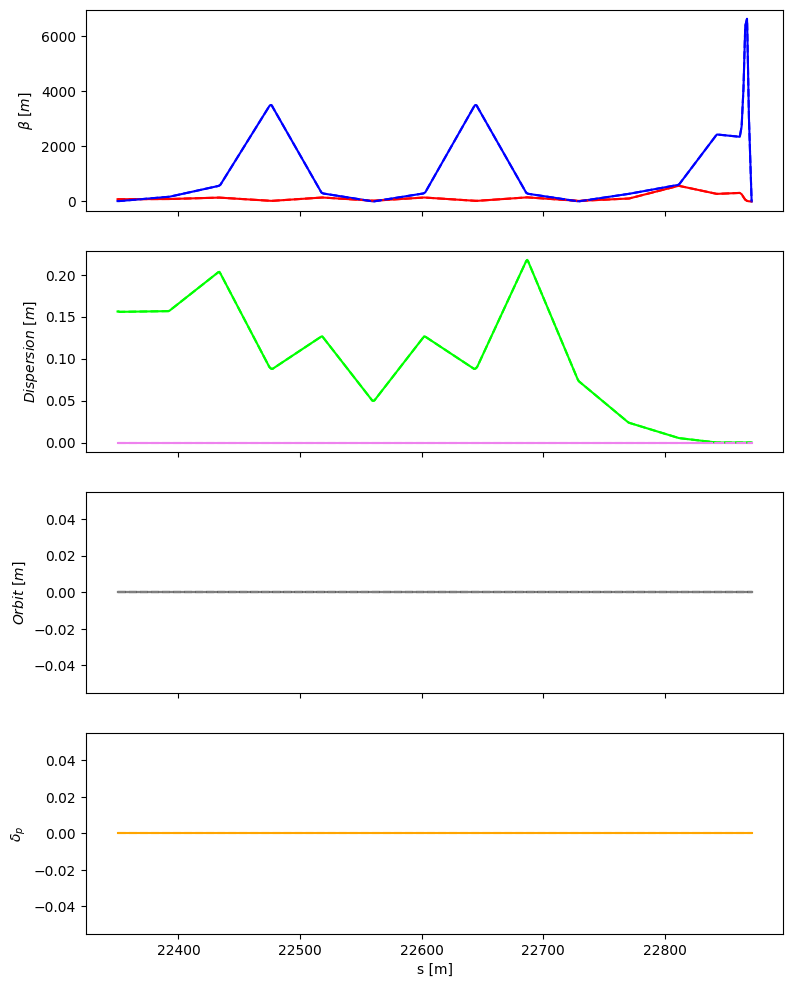

In [16]:
result = mfct.rematch_mccs_yl(line, MATCHING_PARAMETERS[OPERATION_MODE])

result.show()
result.solve()

bxip = 1.0
byip = 0.16E-2
cell_mccs_yl = line.twiss(
    ele_start='ccs_yl.d',
    ele_stop='ipd',
    twiss_init=TwissInit(
        betx=bxip,
        bety=byip,
        element_name='ipd'
    ),
    method='4d',
)
cell_mccs_yl_df_rematched = cell_mccs_yl.to_pandas()

pl.compare_twiss(cell_mccs_yl_thick_df, cell_mccs_yl_df_rematched)

In [17]:
result.log()

Table: 2 rows, 36 cols
iteration     penalty alpha tol_met            target_active      hit_limits vary_active    vary_0 ...
        0 4.05874e-06    -1 yyyyyyyyyyyyyyyyyy yyyyyyyyyyyyyyyyyy nnnnnnnnn  yyyyyyyyy   -0.162048
        1         nan  None yyyyyyyyyyyyyyyyyy yyyyyyyyyyyyyyyyyy nnnnnnnnn  yyyyyyyyy   -0.162048

In [18]:
result = mfct.rematch_mccs_yxl(line, MATCHING_PARAMETERS[OPERATION_MODE])
result.target_status()

Found suitable prebuilt kernel `default_bb3d`.
Using solver jacobian
Found point within tolerance!   
penalty: 5.368546962830094e-06
new best: 5.368546962830094e-06
id state tag tol_met  current_val target_val ...
 0 ON           True            0          0
 1 ON           True            0          0
 2 ON           True            0          0
 3 ON           True            0          0
 4 ON           True            0          0
 5 ON           True            0          0
 6 ON           True            0          0
 7 ON           True            0          0
 8 ON           True            0          0
 9 ON           True            0          0
10 ON           True            0          0
11 ON           True           -1         -1
12 ON           True  5.36761e-06          0
13 ON           True           -1         -1
14 ON           True -2.49908e-09          0
15 ON           True  3.12888e-08          0
16 ON           True  9.62898e-12          0
17 ON           True 

Found suitable prebuilt kernel `default_bb3d`.
Using solver jacobian
Found point within tolerance!   
penalty: 5.368546962830094e-06
new best: 5.368546962830094e-06
Vary:
id tag state description                                          
 0     ON    Vary(name=kqd07, limits=None, step=1e-10, weight=1.0)
 1     ON    Vary(name=kqf08, limits=None, step=1e-10, weight=1.0)
 2     ON    Vary(name=kqd09, limits=None, step=1e-10, weight=1.0)
 3     ON    Vary(name=kqf10, limits=None, step=1e-10, weight=1.0)
 4     ON    Vary(name=kqd11, limits=None, step=1e-10, weight=1.0)
 5     ON    Vary(name=kqf12, limits=None, step=1e-10, weight=1.0)
 6     ON    Vary(name=kqx00, limits=None, step=1e-10, weight=1.0)
 7     ON    Vary(name=kqx01, limits=None, step=1e-10, weight=1.0)
 8     ON    Vary(name=kqx02, limits=None, step=1e-10, weight=1.0)
 9     ON    Vary(name=kqf13, limits=None, step=1e-10, weight=1.0)
10     ON    Vary(name=kqd14, limits=None, step=1e-10, weight=1.0)
11     ON    Vary(name=kq

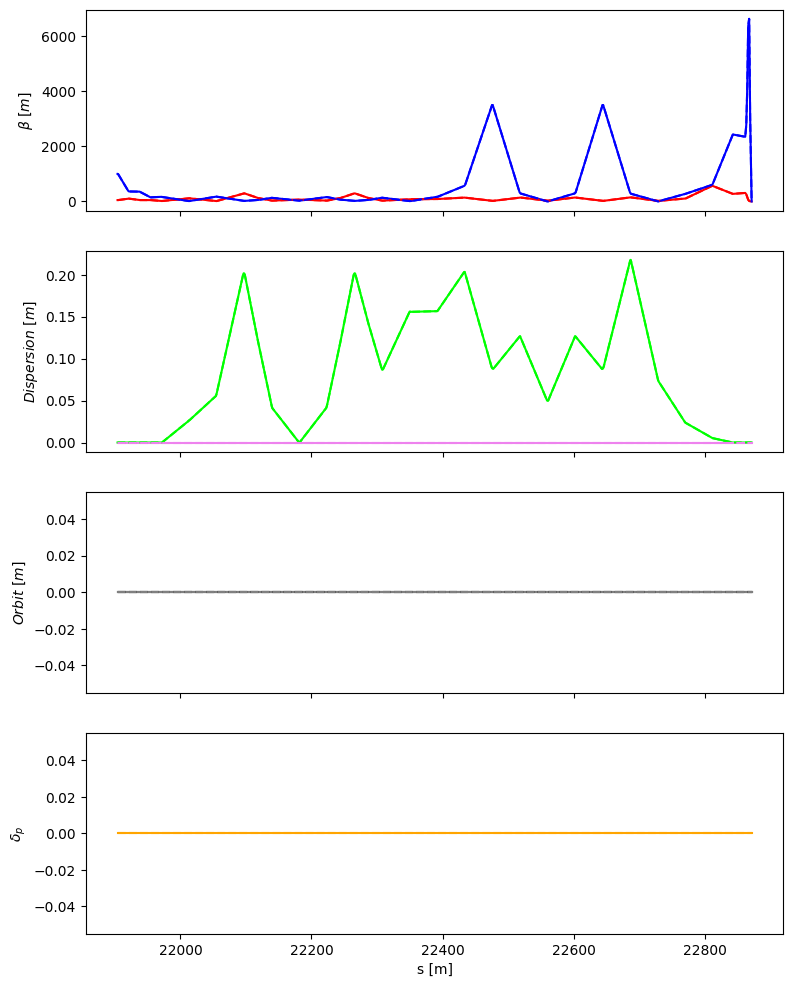

In [19]:
result = mfct.rematch_mccs_yxl(line, MATCHING_PARAMETERS[OPERATION_MODE])

result.show()
result.solve()

cell_mccs_yxl = line.twiss(
    ele_start='ccs_xl.d',
    ele_stop='ipd',
    twiss_init=TwissInit(
        betx=bxip,
        bety=byip,
        element_name='ipd'
    ),
    method='4d',
)
cell_mccs_yxl_df_rematched = cell_mccs_yxl.to_pandas()

pl.compare_twiss(cell_mccs_yxl_thick_df, cell_mccs_yxl_df_rematched)

In [20]:
result.log()

Table: 2 rows, 59 cols
iteration     penalty alpha tol_met                           target_active                     ...
        0 5.36855e-06    -1 yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy
        1         nan  None yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy

In [21]:
# define strategy for elements and perform slicing

slicing_strategies = [
    Strategy(slicing=Teapot(10)),  # Default catch-all as in MAD-X
    Strategy(slicing=Teapot(5), element_type=xt.Bend),
    Strategy(slicing=Teapot(5), element_type=xt.Quadrupole),
    Strategy(slicing=Teapot(5), element_type=xt.Sextupole),
    Strategy(slicing=Teapot(5), element_type=xt.Multipole),
    Strategy(slicing=Teapot(15), name=r'^qd0.*'),
    Strategy(slicing=Teapot(15), name=r'^qf1.*'),
    Strategy(slicing=Teapot(15), name=r'^qf2.*'),
    Strategy(slicing=Teapot(15), name=r'^qd2.*'),
]

line.discard_tracker()
print("Slicing thick elements...")
line.slice_thick_elements(slicing_strategies)

print("Building tracker...")
line.build_tracker()
thin_twiss = line.twiss().to_pandas()
thin_twiss

Slicing thick elements...
Building tracker...
Found suitable prebuilt kernel `default_bb3d`.


name             s             x            px  \
0       fccee_p_ring$start      0.000000  2.130314e-11  2.877991e-11   
1                       ip      0.000000  2.130314e-11  2.877991e-11   
2                      ipa      0.000000  2.130314e-11  2.877991e-11   
3                       d0      0.000000  2.130314e-11  2.877991e-11   
4              qd0al_entry      2.200000  8.461894e-11  2.877991e-11   
...                    ...           ...           ...           ...   
271335                d0:6  91483.610288  7.536504e-11 -2.114313e-11   
271336                ip:6  91485.810288  2.885015e-11 -2.114313e-11   
271337               ipa.l  91485.810288  2.885015e-11 -2.114313e-11   
271338    fccee_p_ring$end  91485.810288  2.885015e-11 -2.114313e-11   
271339          _end_point  91485.810288  2.885015e-11 -2.114313e-11   

                   y            py      zeta         delta          ptau  \
0      -1.660343e-22 -4.655166e-20 -0.067767 -7.042922e-12 -7.042922e-12   
1      -1.660343e-22 -4.655166e-20 -0.067767 -7.042922e-12 -7.042922e-12   
2      -1.660343e-22 -4.655166e-20 -0.067767 -7.042922e-12 -7.042922e-12   
3      -1.660343e-22 -4.655166e-20 -0.067767 -7.042922e-12 -7.042922e-12   
4      -1.025797e-19 -4.655166e-20 -0.067767 -7.042922e-12 -7.042922e-12   
...              ...           ...       ...           ...           ...   
271335 -1.448165e-19  6.589060e-20 -0.067767  2.805756e-12  2.805913e-12   
271336  1.428569e-22  6.589060e-20 -0.067767  2.805756e-12  2.805913e-12   
271337  1.428569e-22  6.589060e-20 -0.067767  2.805756e-12  2.805913e-12   
271338  1.428569e-22  6.589060e-20 -0.067767  2.805756e-12  2.805913e-12   
271339  1.428569e-22  6.589060e-20 -0.067767  2.805756e-12  2.805913e-12   

            betx  ...         mux         muy    muzeta  nux  nuy    nuzeta  \
0       0.996436  ...    0.000000    0.000000  0.000000  1.0  1.0  1.000000   
1       0.996436  ...    0.000000    0.000000  0.000000  1.0  1.0  1.000000   
2       0.996436  ...    0.000000    0.000000  0.000000  1.0  1.0  1.000000   
3       0.996436  ...    0.000000    0.000000  0.000000  1.0  1.0  1.000000   
4       5.853803  ...    0.182312    0.250014  0.000000  1.0  1.0  1.000000   
...          ...  ...         ...         ...       ...  ...  ...       ...   
271335  5.853694  ...  362.066384  322.214305 -0.103636  1.0  1.0  1.000075   
271336  0.996436  ...  362.248700  322.464029 -0.103636  1.0  1.0  1.000075   
271337  0.996436  ...  362.248700  322.464029 -0.103636  1.0  1.0  1.000075   
271338  0.996436  ...  362.248700  322.464029 -0.103636  1.0  1.0  1.000075   
271339  0.996436  ...  362.248700  322.464029 -0.103636  1.0  1.0  1.000075   

                                                 W_matrix     dzeta      dmux  \
0       [[0.9982162718101986, 1.222462362129164e-16, 0...  0.000000  0.000000   
1       [[0.9982162718101986, 1.222462362129164e-16, 0...  0.000000  0.000000   
2       [[0.9982162718101986, 1.222462362129164e-16, 0...  0.000000  0.000000   
3       [[0.9982162718101986, 1.222462362129164e-16, 0...  0.000000  0.000000   
4       [[2.4194633569446027, -8.394946991901713e-17, ...  0.000000 -0.184345   
...                                                   ...       ...       ...   
271335  [[2.419440922993512, -2.8859611287785846e-16, ... -0.975865  1.977716   
271336  [[0.9982162676235748, 9.690449002331306e-17, -... -0.975865  1.841678   
271337  [[0.9982162676235748, 9.690449002331306e-17, -... -0.975865  1.841678   
271338  [[0.9982162676235748, 9.690449002331306e-17, -... -0.975865  1.841678   
271339  [[0.9982162676235748, 9.690449002331306e-17, -... -0.975865  1.841678   

            dmuy  
0       0.000000  
1       0.000000  
2       0.000000  
3       0.000000  
4       0.113958  
...          ...  
271335  0.495668  
271336  0.380625  
271337  0.380625  
271338  0.380625  
271339  0.380625  

[271340 rows x 35 columns]

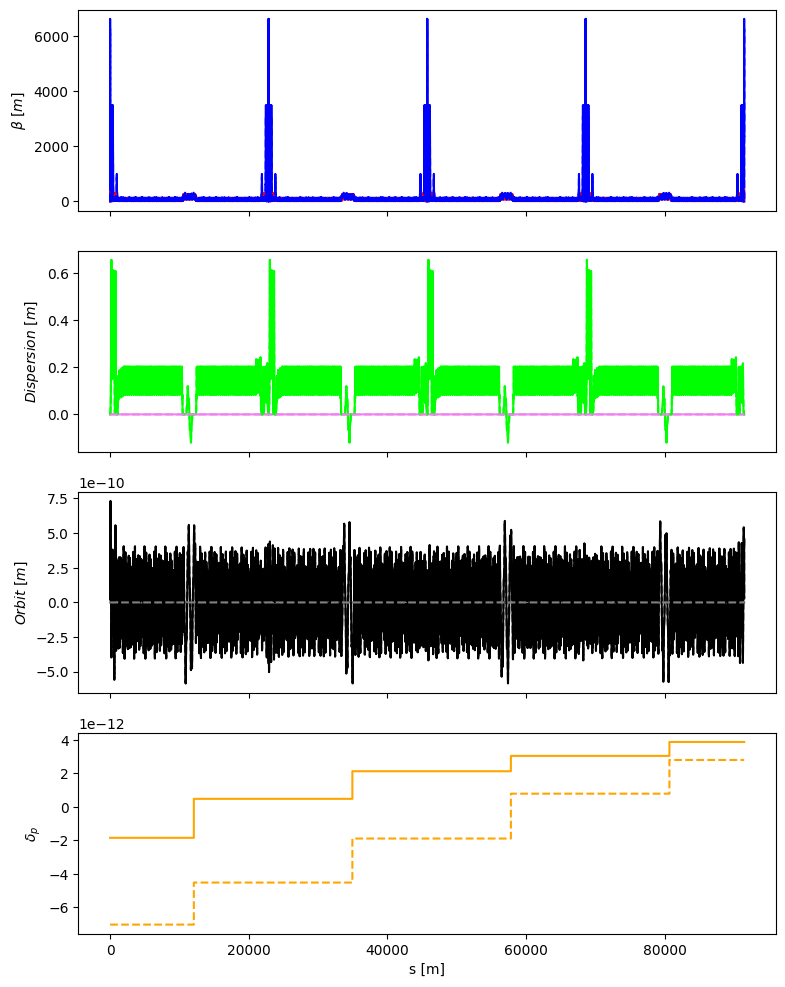

In [22]:
pl.compare_twiss(thick_twiss, thin_twiss)

In [23]:
# make twiss for before/after comparison
cell_uu = line.twiss(
    ele_start='s.arc_uu',
    ele_stop='e.arc_uu',
    twiss_init='periodic',
    method='4d',
)
cell_uu_df = cell_uu.to_pandas()

cell_ussu = line.twiss(
    ele_start='s.arc_ussu',
    ele_stop='e.arc_ussu',
    twiss_init=TwissInit(
            betx=cell_uu['betx', -1],
            bety=cell_uu['bety', -1],
            dx=cell_uu['dx', -1],
        ),
    method='4d',
)
cell_ussu_df = cell_ussu.to_pandas()

cell_uffu = line.twiss(
    ele_start='s.arc_uffu',
    ele_stop='e.arc_uffu',
    twiss_init=TwissInit(
            betx=cell_uu['betx', -1],
            bety=cell_uu['bety', -1],
            dx=cell_uu['dx', -1],
        ),
    method='4d',
)
cell_uffu_df = cell_uffu.to_pandas()


cell_ufl = line.twiss(
    ele_start='s.arc_uffu',
    ele_stop='ccs_xl.d',
    twiss_init=TwissInit(
            betx=cell_uu['betx', -1],
            bety=cell_uu['bety', -1],
            dx=cell_uu['dx', -1],
        ),
    method='4d',
)
cell_ufl_df = cell_ufl.to_pandas().set_index('name')

bx_ff_in = 50.0
by_ff_in = 1.0E3
dx_ff_in = 0.0
cell_ufr = line.twiss(
    ele_start='ccs_xr.d',
    ele_stop='e.arc_uffu',
    twiss_init=TwissInit(
        betx=bx_ff_in,
        bety=by_ff_in,
        dx=dx_ff_in,
    ),
    method='4d',
)
cell_ufr_df = cell_ufr.to_pandas().set_index('name')

bxip = 1.0
byip = 0.16E-2
cell_mccs_yl = line.twiss(
    ele_start='ccs_yl.d',
    ele_stop='ipd',
    twiss_init=TwissInit(
        betx=bxip,
        bety=byip,
        element_name='ipd'
    ),
    method='4d',
)
cell_mccs_yl_df = cell_mccs_yl.to_pandas()

cell_mccs_yxl = line.twiss(
    ele_start='ccs_xl.d',
    ele_stop='ipd',
    twiss_init=TwissInit(
        betx=bxip,
        bety=byip,
        element_name='ipd'
    ),
    method='4d',
)
cell_mccs_yxl_df = cell_mccs_yxl.to_pandas()


Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `only_xtrack_backtrack_frozen_energy`.
Found suitable prebuilt kernel `default_bb3d`.


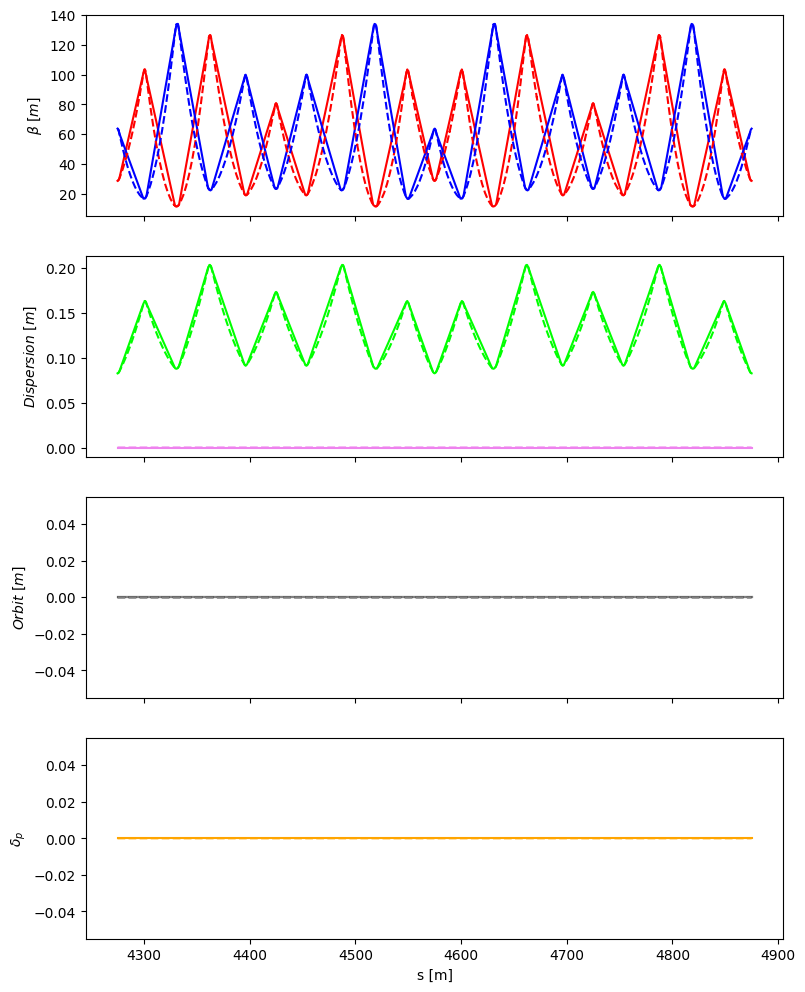

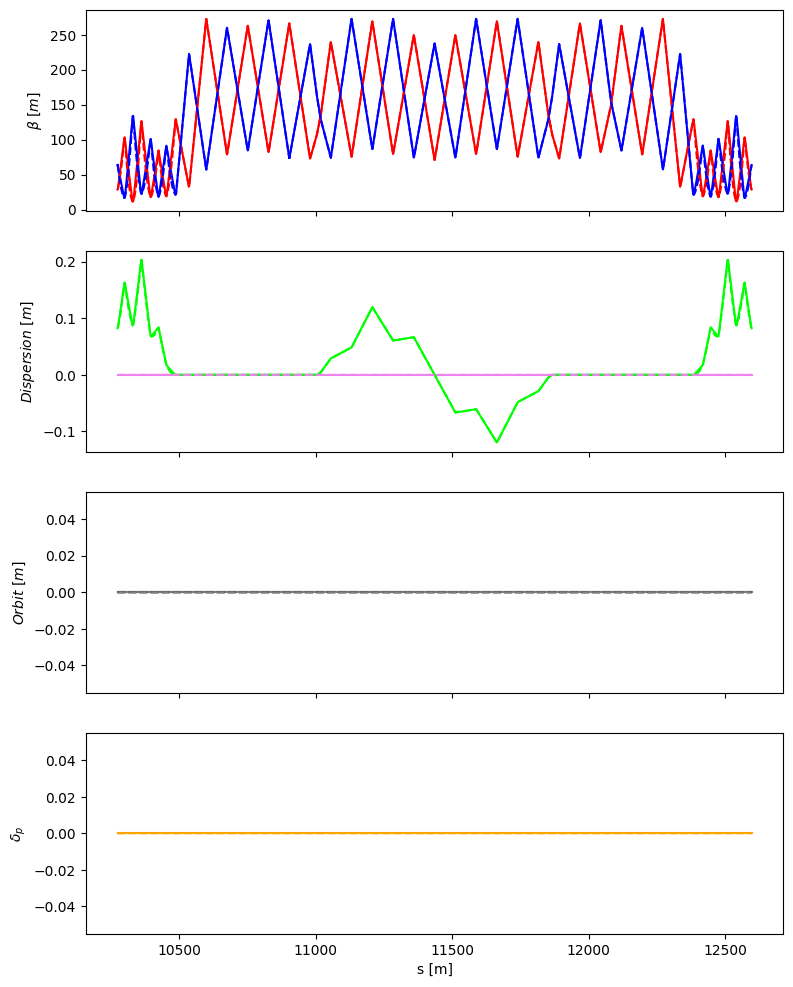

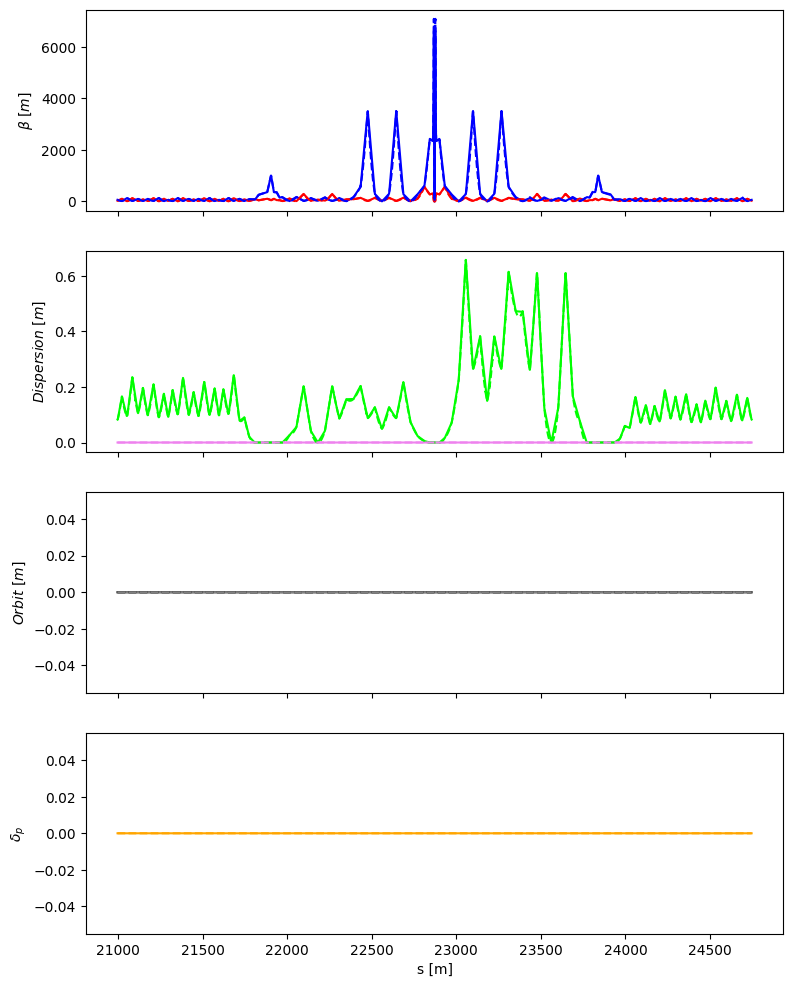

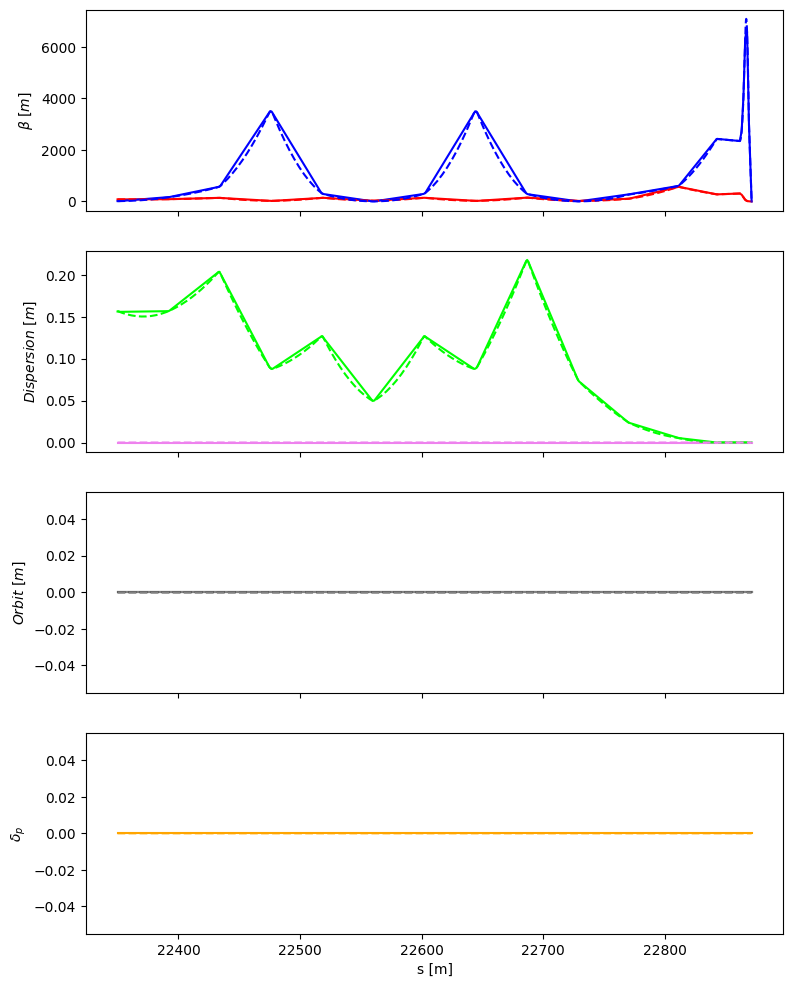

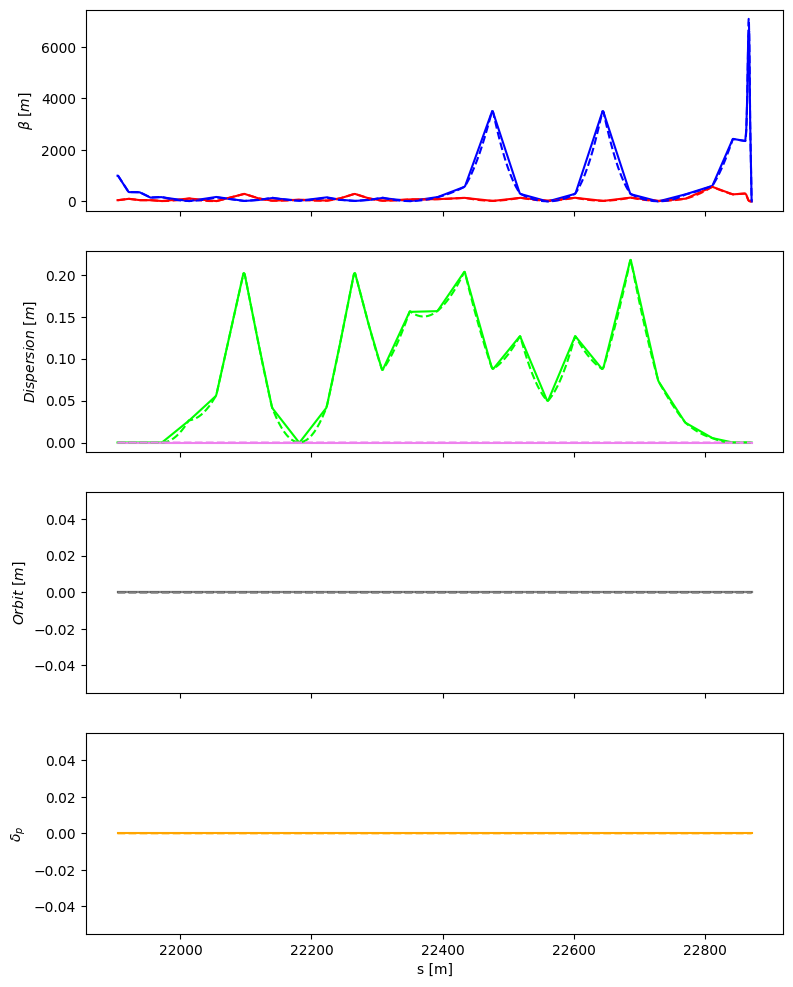

In [24]:
pl.compare_twiss(cell_uu_thick_df, cell_uu_df)
pl.compare_twiss(cell_ussu_thick_df, cell_ussu_df)
pl.compare_twiss(cell_uffu_thick_df, cell_uffu_df)
pl.compare_twiss(cell_mccs_yl_thick_df, cell_mccs_yl_df)
pl.compare_twiss(cell_mccs_yxl_thick_df, cell_mccs_yxl_df)

In [25]:
# rematch thin lattice


Using solver jacobian
penalty: 0.00040710116002856797 
new best: 0.00040710116002856797
Vary:
id tag state description                                         
 0     ON    Vary(name=kqd1, limits=None, step=1e-10, weight=1.0)
 1     ON    Vary(name=kqf2, limits=None, step=1e-10, weight=1.0)
 2     ON    Vary(name=kqd3, limits=None, step=1e-10, weight=1.0)
 3     ON    Vary(name=kqf4, limits=None, step=1e-10, weight=1.0)
 4     ON    Vary(name=kqd5, limits=None, step=1e-10, weight=1.0)
 5     ON    Vary(name=kqf6, limits=None, step=1e-10, weight=1.0)
Targets:
id tag state description                                                                            
 0     ON    TargetInequality(('bety', 'sd1a_exit:64') > 132.1, tol=0.0001, weight=1.0)             
 1     ON    Target(tar=('mux', 'sd1a_exit:64'), value=0.25057, tol=0.0001, weight=10.0)            
 2     ON    Target(tar=('muy', 'sd1a_exit:64'), value=0.2527, tol=0.0001, weight=10.0)             
 3     ON    Target(tar=('betx'

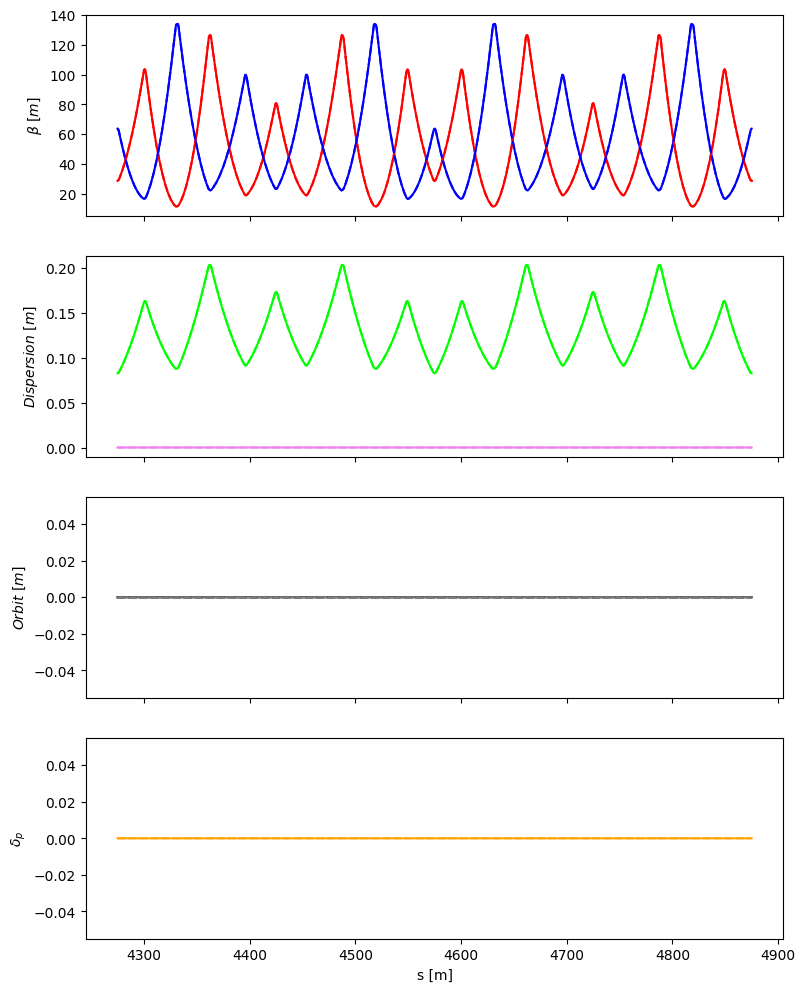

In [26]:
result = mfct.rematch_arcuu(line, MATCHING_PARAMETERS[OPERATION_MODE])

result.show()
result.solve()

cell_uu = line.twiss(
    ele_start='s.arc_uu',
    ele_stop='e.arc_uu',
    twiss_init='periodic',
    method='4d',
)
cell_uu_df_rematched = cell_uu.to_pandas()

pl.compare_twiss(cell_uu_df, cell_uu_df_rematched)

Found suitable prebuilt kernel `default_bb3d`.
Using solver jacobian
penalty: 0.004354584725684998   
new best: 0.004354584725684998
Vary:
id tag state description                                          
 0     ON    Vary(name=kqfs1, limits=None, step=1e-10, weight=1.0)
 1     ON    Vary(name=kqds2, limits=None, step=1e-10, weight=1.0)
 2     ON    Vary(name=kqfs3, limits=None, step=1e-10, weight=1.0)
 3     ON    Vary(name=kqds4, limits=None, step=1e-10, weight=1.0)
 4     ON    Vary(name=kqfs5, limits=None, step=1e-10, weight=1.0)
 5     ON    Vary(name=kqdl1, limits=None, step=1e-10, weight=1.0)
 6     ON    Vary(name=kqfl2, limits=None, step=1e-10, weight=1.0)
 7     ON    Vary(name=kqdl2, limits=None, step=1e-10, weight=1.0)
 8     ON    Vary(name=kqfl3, limits=None, step=1e-10, weight=1.0)
 9     ON    Vary(name=kqdl3, limits=None, step=1e-10, weight=1.0)
10     ON    Vary(name=kqdl4, limits=None, step=1e-10, weight=1.0)
Targets:
id tag state description                        

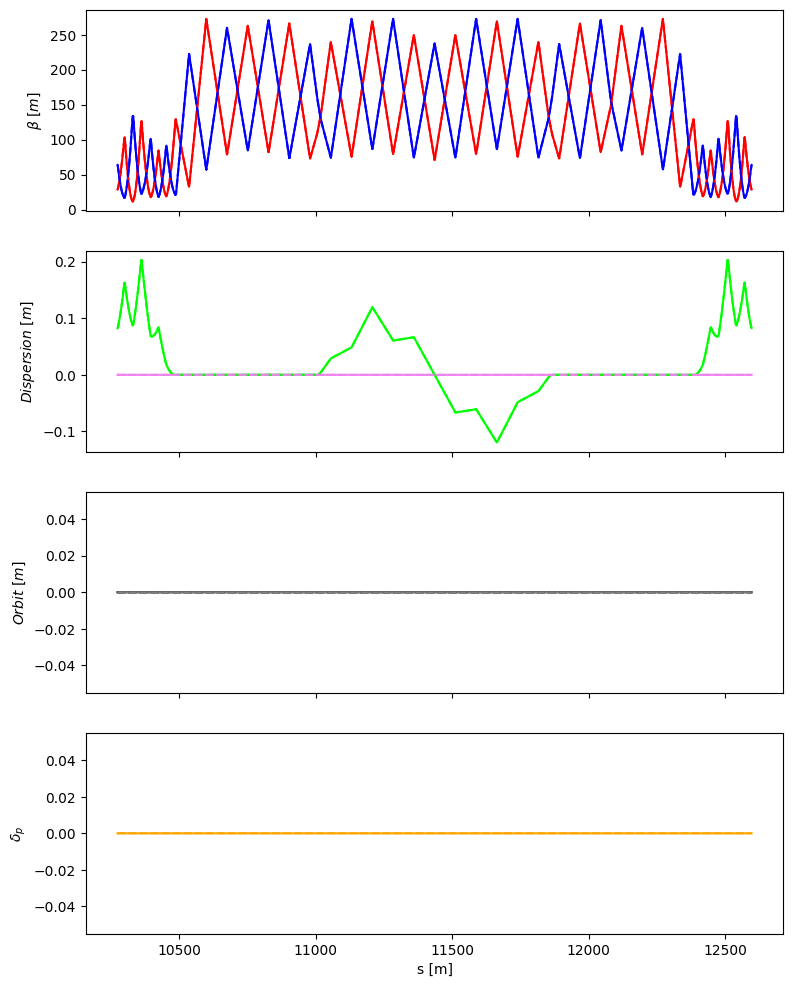

In [27]:
result = mfct.rematch_arcussu(line, MATCHING_PARAMETERS[OPERATION_MODE])

result.show()
result.solve()

cell_ussu = line.twiss(
    ele_start='s.arc_ussu',
    ele_stop='e.arc_ussu',
    twiss_init=TwissInit(
            betx=cell_uu['betx', -1],
            bety=cell_uu['bety', -1],
            dx=cell_uu['dx', -1],
        ),
    method='4d',
)
cell_ussu_df_rematched = cell_ussu.to_pandas()

pl.compare_twiss(cell_ussu_df, cell_ussu_df_rematched)

Found suitable prebuilt kernel `default_bb3d`.
Using solver jacobian
penalty: 0.019515426657399148   
new best: 0.019515426657399148
Vary:
id tag state description                                           
 0     ON    Vary(name=kqfm1l, limits=None, step=1e-10, weight=1.0)
 1     ON    Vary(name=kqdm2l, limits=None, step=1e-10, weight=1.0)
 2     ON    Vary(name=kqfm3l, limits=None, step=1e-10, weight=1.0)
 3     ON    Vary(name=kqdm4l, limits=None, step=1e-10, weight=1.0)
 4     ON    Vary(name=kqfm5l, limits=None, step=1e-10, weight=1.0)
 5     ON    Vary(name=kqdm6l, limits=None, step=1e-10, weight=1.0)
 6     ON    Vary(name=kqfm7l, limits=None, step=1e-10, weight=1.0)
 7     ON    Vary(name=kqdm8l, limits=None, step=1e-10, weight=1.0)
Targets:
id tag state description                                                                            
 0     ON    Target(tar=('betx', 'scrabl_exit:0'), value=50.0, tol=0.0001, weight=1.0)              
 1     ON    Target(tar=('bety', 'scra

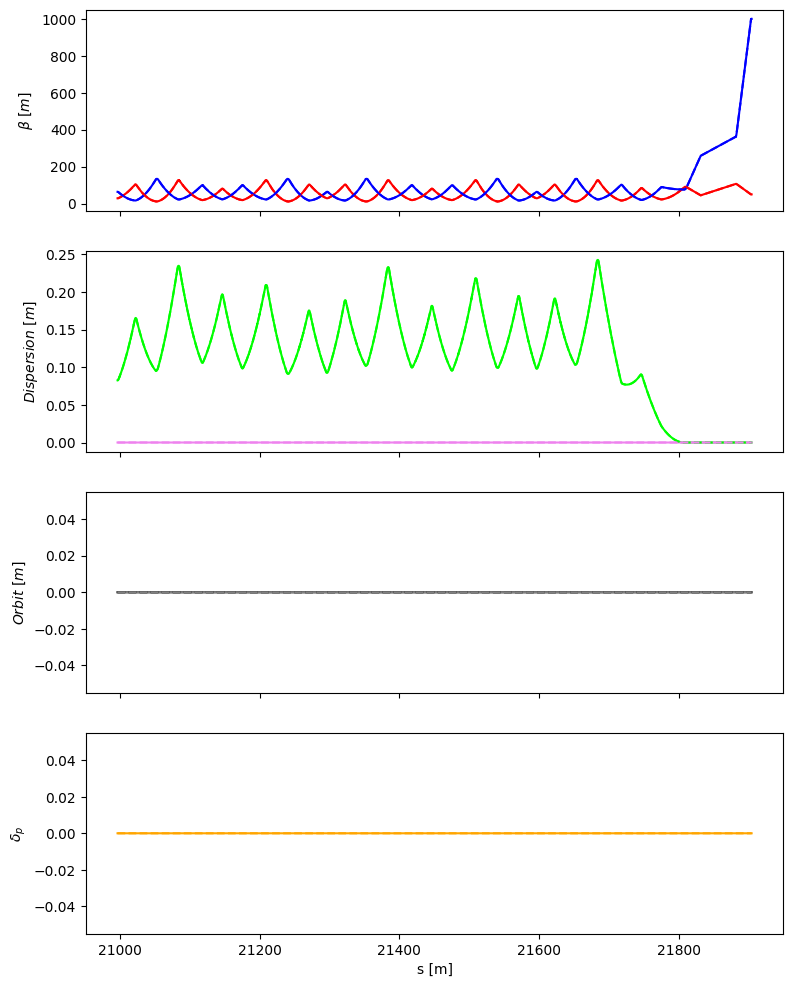

In [28]:
result = mfct.rematch_arcufl(line, MATCHING_PARAMETERS[OPERATION_MODE])

result.show()
result.solve()

cell_ufl = line.twiss(
    ele_start='s.arc_uffu',
    ele_stop='ccs_xl.d',
    twiss_init=TwissInit(
            betx=cell_uu['betx', -1],
            bety=cell_uu['bety', -1],
            dx=cell_uu['dx', -1],
        ),
    method='4d',
)
cell_ufl_df_rematched = cell_ufl.to_pandas()

pl.compare_twiss(cell_ufl_df, cell_ufl_df_rematched)

Found suitable prebuilt kernel `default_bb3d`.
Using solver jacobian
penalty: 0.00032361052170728523 
new best: 0.00032361052170728523
Vary:
id tag state description                                           
 0     ON    Vary(name=kqfm1r, limits=None, step=1e-10, weight=1.0)
 1     ON    Vary(name=kqdm2r, limits=None, step=1e-10, weight=1.0)
 2     ON    Vary(name=kqfm3r, limits=None, step=1e-10, weight=1.0)
 3     ON    Vary(name=kqdm4r, limits=None, step=1e-10, weight=1.0)
 4     ON    Vary(name=kqfm5r, limits=None, step=1e-10, weight=1.0)
 5     ON    Vary(name=kqdm6r, limits=None, step=1e-10, weight=1.0)
 6     ON    Vary(name=kqfm7r, limits=None, step=1e-10, weight=1.0)
 7     ON    Vary(name=kqdm8r, limits=None, step=1e-10, weight=1.0)
Targets:
id tag state description                                                                         
 0     ON    Target(tar=('betx', 'e.arc_uffu'), value=28.810839912933766, tol=0.0001, weight=1.0)
 1     ON    Target(tar=('bety', 'e.arc_uf

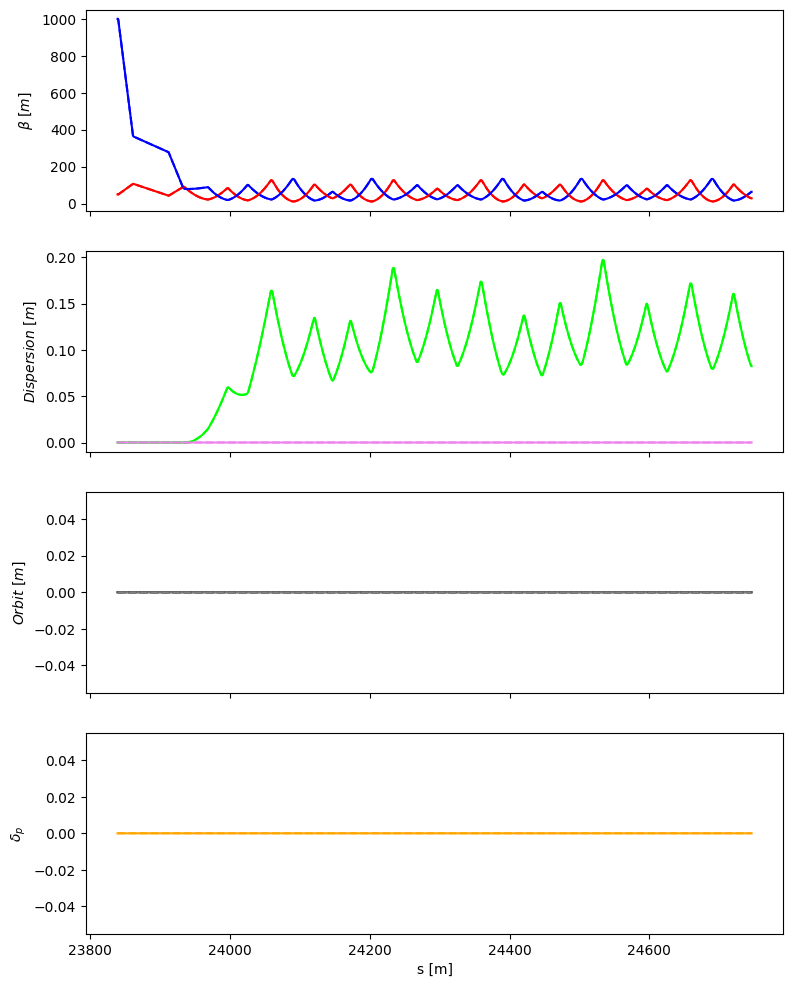

In [29]:
result = mfct.rematch_arcufr(line, MATCHING_PARAMETERS[OPERATION_MODE])

result.show()
result.solve()

cell_ufr = line.twiss(
    ele_start='ccs_xr.d',
    ele_stop='e.arc_uffu',
    twiss_init=TwissInit(
        betx=bx_ff_in,
        bety=by_ff_in,
        dx=dx_ff_in,
    ),
    method='4d',
)
cell_ufr_df_rematched = cell_ufr.to_pandas()

pl.compare_twiss(cell_ufr_df, cell_ufr_df_rematched)

Found suitable prebuilt kernel `default_bb3d`.
Using solver jacobian
penalty: 2.018112931504673      
new best: 2.018112931504673
Vary:
id tag state description                                           
 0     ON    Vary(name=kqd0al, limits=None, step=1e-10, weight=1.0)
 1     ON    Vary(name=kqf1al, limits=None, step=1e-10, weight=1.0)
 2     ON    Vary(name=kqy01, limits=None, step=1e-10, weight=1.0) 
 3     ON    Vary(name=kqy02, limits=None, step=1e-10, weight=1.0) 
 4     ON    Vary(name=kqy03, limits=None, step=1e-10, weight=1.0) 
 5     ON    Vary(name=kqd02, limits=None, step=1e-10, weight=1.0) 
 6     ON    Vary(name=kqd04, limits=None, step=1e-10, weight=1.0) 
 7     ON    Vary(name=kqf05, limits=None, step=1e-10, weight=1.0) 
 8     ON    Vary(name=kqd06, limits=None, step=1e-10, weight=1.0) 
Targets:
id tag state description                                                                               
 0     ON    TargetInequality(('betx', 'ipimag1:0') < 40.0, tol=0.0001,

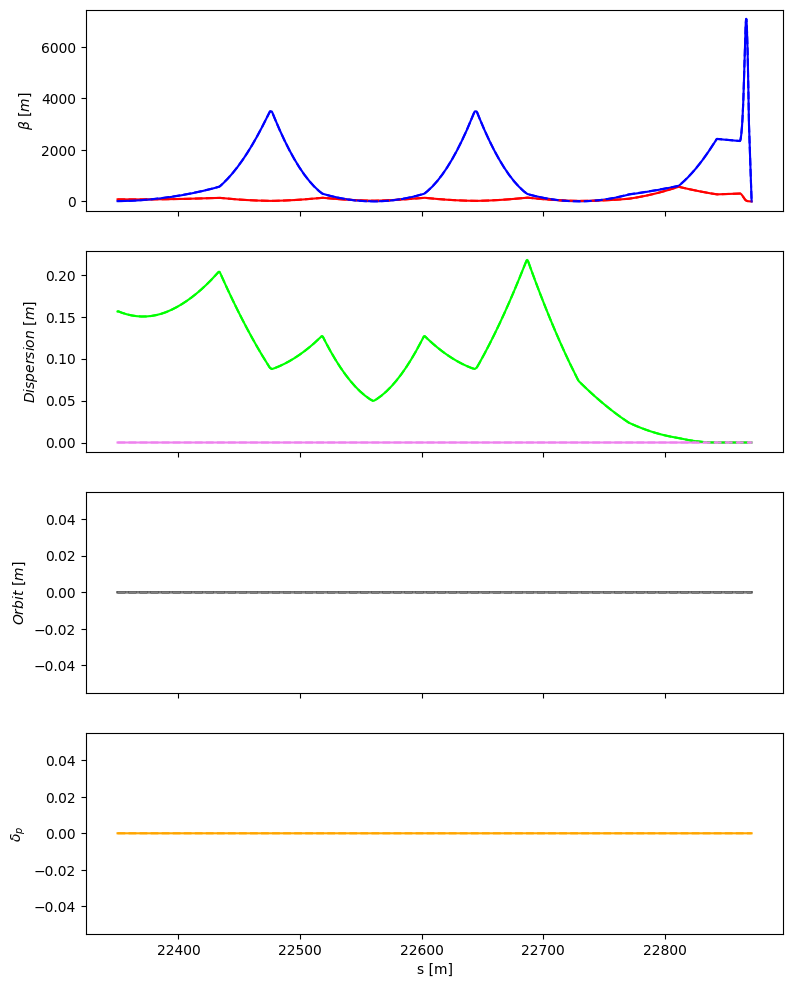

In [30]:
result = mfct.rematch_mccs_yl(line, MATCHING_PARAMETERS[OPERATION_MODE])

result.show()
result.solve()

bxip = 1.0
byip = 0.16E-2
cell_mccs_yl = line.twiss(
    ele_stop='ipd',
    ele_start='ccs_yl.d',
    twiss_init=TwissInit(
        betx=bxip,
        bety=byip,
        element_name='ipd'
    ),
    method='4d',
)
cell_mccs_yl_df_rematched = cell_mccs_yl.to_pandas()

pl.compare_twiss(cell_mccs_yl_df, cell_mccs_yl_df_rematched)

In [31]:
result = mfct.rematch_mccs_yxl(line, MATCHING_PARAMETERS[OPERATION_MODE])
result.target_status()

Found suitable prebuilt kernel `default_bb3d`.
Using solver jacobian
penalty: 0.007946339317018412   
new best: 0.007946339317018412
id state tag tol_met  current_val target_val ...
 0 ON           True            0          0
 1 ON           True            0          0
 2 ON           True            0          0
 3 ON           True            0          0
 4 ON           True            0          0
 5 ON           True            0          0
 6 ON           True            0          0
 7 ON           True            0          0
 8 ON           True            0          0
 9 ON           True            0          0
10 ON           True            0          0
11 ON           True           -1         -1
12 ON           True  7.19527e-05          0
13 ON           True           -1         -1
14 ON           True   1.2475e-05          0
15 ON          False  -0.00040497          0
16 ON           True -9.46991e-09          0
17 ON           True            0          0
18 ON   

Found suitable prebuilt kernel `default_bb3d`.
Using solver jacobian
penalty: 0.007946339317018412   
new best: 0.007946339317018412
Vary:
id tag state description                                          
 0     ON    Vary(name=kqd07, limits=None, step=1e-10, weight=1.0)
 1     ON    Vary(name=kqf08, limits=None, step=1e-10, weight=1.0)
 2     ON    Vary(name=kqd09, limits=None, step=1e-10, weight=1.0)
 3     ON    Vary(name=kqf10, limits=None, step=1e-10, weight=1.0)
 4     ON    Vary(name=kqd11, limits=None, step=1e-10, weight=1.0)
 5     ON    Vary(name=kqf12, limits=None, step=1e-10, weight=1.0)
 6     ON    Vary(name=kqx00, limits=None, step=1e-10, weight=1.0)
 7     ON    Vary(name=kqx01, limits=None, step=1e-10, weight=1.0)
 8     ON    Vary(name=kqx02, limits=None, step=1e-10, weight=1.0)
 9     ON    Vary(name=kqf13, limits=None, step=1e-10, weight=1.0)
10     ON    Vary(name=kqd14, limits=None, step=1e-10, weight=1.0)
11     ON    Vary(name=kqf15, limits=None, step=1e-10, we

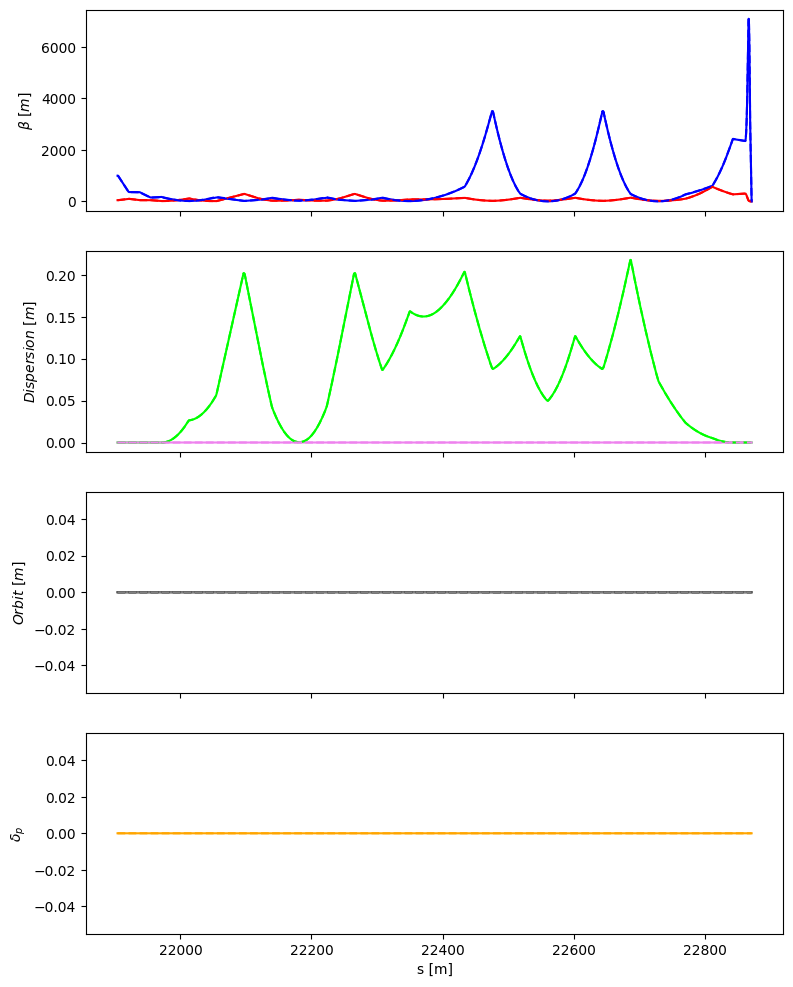

In [32]:
result = mfct.rematch_mccs_yxl(line, MATCHING_PARAMETERS[OPERATION_MODE])

result.show()
result.solve()

cell_mccs_yxl = line.twiss(
    ele_stop='ipd',
    ele_start='ccs_xl.d',
    twiss_init=TwissInit(
        betx=bxip,
        bety=byip,
        element_name='ipd'

    ),
    method='4d',
)
cell_mccs_yxl_df_rematched = cell_mccs_yxl.to_pandas()

pl.compare_twiss(cell_mccs_yxl_df, cell_mccs_yxl_df_rematched)

In [33]:
with open(f'fccee_{OPERATION_MODE}_thin.json', 'w', encoding='utf-8') as fid:
    json.dump(line.to_dict(), fid, cls=xo.JEncoder)

In [34]:
thin_twiss = line.twiss().to_pandas()
thin_twiss

name             s             x            px  \
0       fccee_p_ring$start      0.000000  2.518927e-11  2.857355e-11   
1                       ip      0.000000  2.518927e-11  2.857355e-11   
2                      ipa      0.000000  2.518927e-11  2.857355e-11   
3                       d0      0.000000  2.518927e-11  2.857355e-11   
4              qd0al_entry      2.200000  8.805107e-11  2.857355e-11   
...                    ...           ...           ...           ...   
271335                d0:6  91483.610288  8.399077e-11 -2.519215e-11   
271336                ip:6  91485.810288  2.856804e-11 -2.519215e-11   
271337               ipa.l  91485.810288  2.856804e-11 -2.519215e-11   
271338    fccee_p_ring$end  91485.810288  2.856804e-11 -2.519215e-11   
271339          _end_point  91485.810288  2.856804e-11 -2.519215e-11   

                   y            py      zeta         delta          ptau  \
0       5.083811e-22 -1.624057e-19 -0.067767 -1.811440e-12 -1.811440e-12   
1       5.083811e-22 -1.624057e-19 -0.067767 -1.811440e-12 -1.811440e-12   
2       5.083811e-22 -1.624057e-19 -0.067767 -1.811440e-12 -1.811440e-12   
3       5.083811e-22 -1.624057e-19 -0.067767 -1.811440e-12 -1.811440e-12   
4      -3.567843e-19 -1.624057e-19 -0.067767 -1.811440e-12 -1.811440e-12   
...              ...           ...       ...           ...           ...   
271335  1.168036e-19 -5.334909e-20 -0.067767  3.900658e-12  3.900716e-12   
271336 -5.643443e-22 -5.334909e-20 -0.067767  3.900658e-12  3.900716e-12   
271337 -5.643443e-22 -5.334909e-20 -0.067767  3.900658e-12  3.900716e-12   
271338 -5.643443e-22 -5.334909e-20 -0.067767  3.900658e-12  3.900716e-12   
271339 -5.643443e-22 -5.334909e-20 -0.067767  3.900658e-12  3.900716e-12   

            betx  ...         mux         muy    muzeta  nux  nuy    nuzeta  \
0       0.999634  ...    0.000000    0.000000  0.000000  1.0  1.0  1.000000   
1       0.999634  ...    0.000000    0.000000  0.000000  1.0  1.0  1.000000   
2       0.999634  ...    0.000000    0.000000  0.000000  1.0  1.0  1.000000   
3       0.999634  ...    0.000000    0.000000  0.000000  1.0  1.0  1.000000   
4       5.841461  ...    0.182120    0.250048  0.000000  1.0  1.0  1.000000   
...          ...  ...         ...         ...       ...  ...  ...       ...   
271335  5.841354  ...  362.067843  322.151031 -0.103613  1.0  1.0  1.000044   
271336  0.999634  ...  362.249967  322.400752 -0.103613  1.0  1.0  1.000044   
271337  0.999634  ...  362.249967  322.400752 -0.103613  1.0  1.0  1.000044   
271338  0.999634  ...  362.249967  322.400752 -0.103613  1.0  1.0  1.000044   
271339  0.999634  ...  362.249967  322.400752 -0.103613  1.0  1.0  1.000044   

                                                 W_matrix     dzeta      dmux  \
0       [[0.9998167649763101, 1.2244224009620996e-16, ...  0.000000  0.000000   
1       [[0.9998167649763101, 1.2244224009620996e-16, ...  0.000000  0.000000   
2       [[0.9998167649763101, 1.2244224009620996e-16, ...  0.000000  0.000000   
3       [[0.9998167649763101, 1.2244224009620996e-16, ...  0.000000  0.000000   
4       [[2.416911515920942, 9.54097350068806e-17, 0.0...  0.000000 -0.182981   
...                                                   ...       ...       ...   
271335  [[2.4168893963668103, -2.404572197794818e-16, ... -0.975492  1.973582   
271336  [[0.999816770205746, -5.074636939501584e-17, 4... -0.975492  1.840208   
271337  [[0.999816770205746, -5.074636939501584e-17, 4... -0.975492  1.840208   
271338  [[0.999816770205746, -5.074636939501584e-17, 4... -0.975492  1.840208   
271339  [[0.999816770205746, -5.074636939501584e-17, 4... -0.975492  1.840208   

            dmuy  
0       0.000000  
1       0.000000  
2       0.000000  
3       0.000000  
4      -0.111379  
...          ...  
271335  0.466205  
271336  0.576208  
271337  0.576208  
271338  0.576208  
271339  0.576208  

[271340 rows x 35 columns]

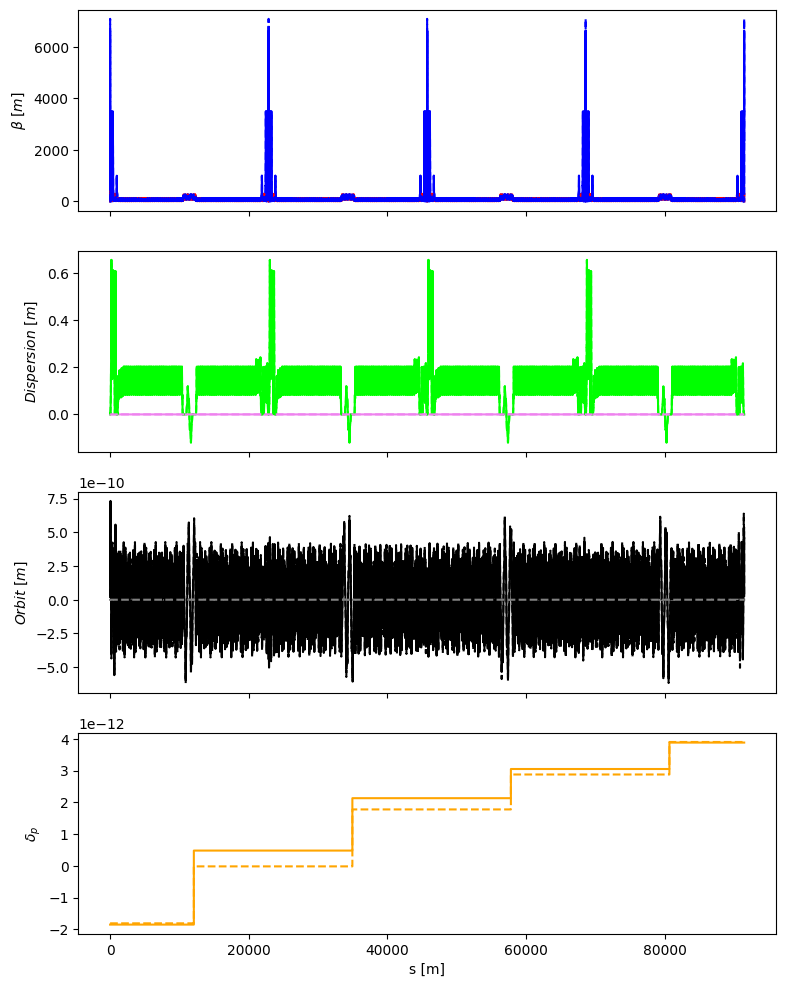

In [35]:
pl.compare_twiss(thick_twiss, thin_twiss)